In [31]:
# imports
import os
# for the model
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, InputLayer, SimpleRNN, LSTM, Reshape , BatchNormalization, Dropout 
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split

# for data manipulation and graphing
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

tf.random.set_seed(42) # set seed for reproducibility
tf.debugging.set_log_device_placement(False)

## Data preprocessing

In [2]:
# load the dataset
# connectium
# original_dataset = pd.read_csv("C:/Users/franc/pasantia_IA/datasets/data_connectium.csv")
# another enterprise
original_dataset = pd.read_csv("C:/Users/franc/pasantia_IA/datasets/data_sip.csv")

# show the original data
original_dataset.head()

,Task_ID,Priority,Project_ID,Project_code,Category,Total_developers,TaskPerformance,DeveloperPerformance,Hours_estimate,Hours_logged,Difference
0,7963,4,9,PC9,Release,1,-8.95,-5.95,3.0,11.95,8.95
1,7963,4,9,PC9,Release,1,-8.95,NaN,3.0,11.95,8.95
2,12609,1,6,PC6,Enhancement,1,-8.94,-8.94,35.0,43.94,8.94
3,13397,1,5,PC5,Testing,1,-8.92,-8.92,14.0,22.92,8.92
4,6063,1,9,PC9,Enhancement,1,8.82,NaN,35.0,26.18,8.82


In [3]:
# show the metadata
original_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4267 entries, 0 to 4266
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Task_ID               4267 non-null   int64  
 1   Priority              4267 non-null   int64  
 2   Project_ID            4267 non-null   int64  
 3   Project_code          4267 non-null   object 
 4   Category              4267 non-null   object 
 5   Total_developers      4267 non-null   int64  
 6   TaskPerformance       4267 non-null   float64
 7   DeveloperPerformance  3830 non-null   float64
 8   Hours_estimate        4267 non-null   float64
 9   Hours_logged          4267 non-null   float64
 10  Difference            4267 non-null   float64
dtypes: float64(5), int64(4), object(2)
memory usage: 366.8+ KB


In [4]:
# drop all the unnecessary columns
clean_dataset = original_dataset[[
    'Task_ID',
    'Project_ID',
    'Priority',
    'Category',
    'Total_developers',
    'Hours_estimate',
    'Hours_logged',
]]

# desnormalizing data
clean_dataset = pd.get_dummies(clean_dataset, columns=['Category'])
clean_dataset = clean_dataset.astype(int)

# check if is necessary to drop any row with NaN/empty/null values

In [5]:
clean_dataset.head()

,Task_ID,Project_ID,Priority,Total_developers,Hours_estimate,Hours_logged,Category_Bug,Category_Enhancement,Category_Release,Category_Testing
0,7963,9,4,1,3,11,0,0,1,0
1,7963,9,4,1,3,11,0,0,1,0
2,12609,6,1,1,35,43,0,1,0,0
3,13397,5,1,1,14,22,0,0,0,1
4,6063,9,1,1,35,26,0,1,0,0


In [6]:
clean_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4267 entries, 0 to 4266
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Task_ID               4267 non-null   int32
 1   Project_ID            4267 non-null   int32
 2   Priority              4267 non-null   int32
 3   Total_developers      4267 non-null   int32
 4   Hours_estimate        4267 non-null   int32
 5   Hours_logged          4267 non-null   int32
 6   Category_Bug          4267 non-null   int32
 7   Category_Enhancement  4267 non-null   int32
 8   Category_Release      4267 non-null   int32
 9   Category_Testing      4267 non-null   int32
dtypes: int32(10)
memory usage: 166.8 KB


### Data sampling

Split the data into train, test and validate samples to fit and evaluate the model

The percentage of each one will be

- 60% training
- 20% testing
- 20% validating

In [7]:
train_dataset, temp_test_dataset = train_test_split(clean_dataset, test_size=0.4)

validation_dataset, test_dataset = train_test_split(temp_test_dataset, test_size=0.50)

print("Samples shape")
print(f"    Train: {train_dataset.shape}")
print(f"    Test: {test_dataset.shape}")
print(f"    Validation: {validation_dataset.shape}")

Samples shape
    Train: (2560, 10)
    Test: (854, 10)
    Validation: (853, 10)


### Data analysis

Calculate the correlation and other statistics on the train dataset

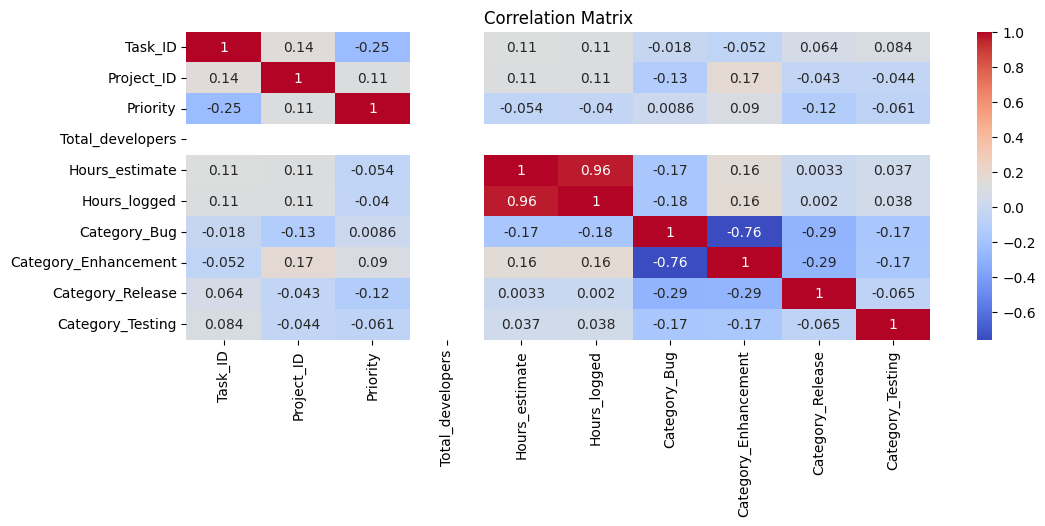

In [8]:
# correlation between the features and the target

correlation_matrix = clean_dataset.corr()
correlation_matrix['Hours_logged'].sort_values(ascending=False)

# plot the correlation matrix
plt.figure(figsize=(12, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

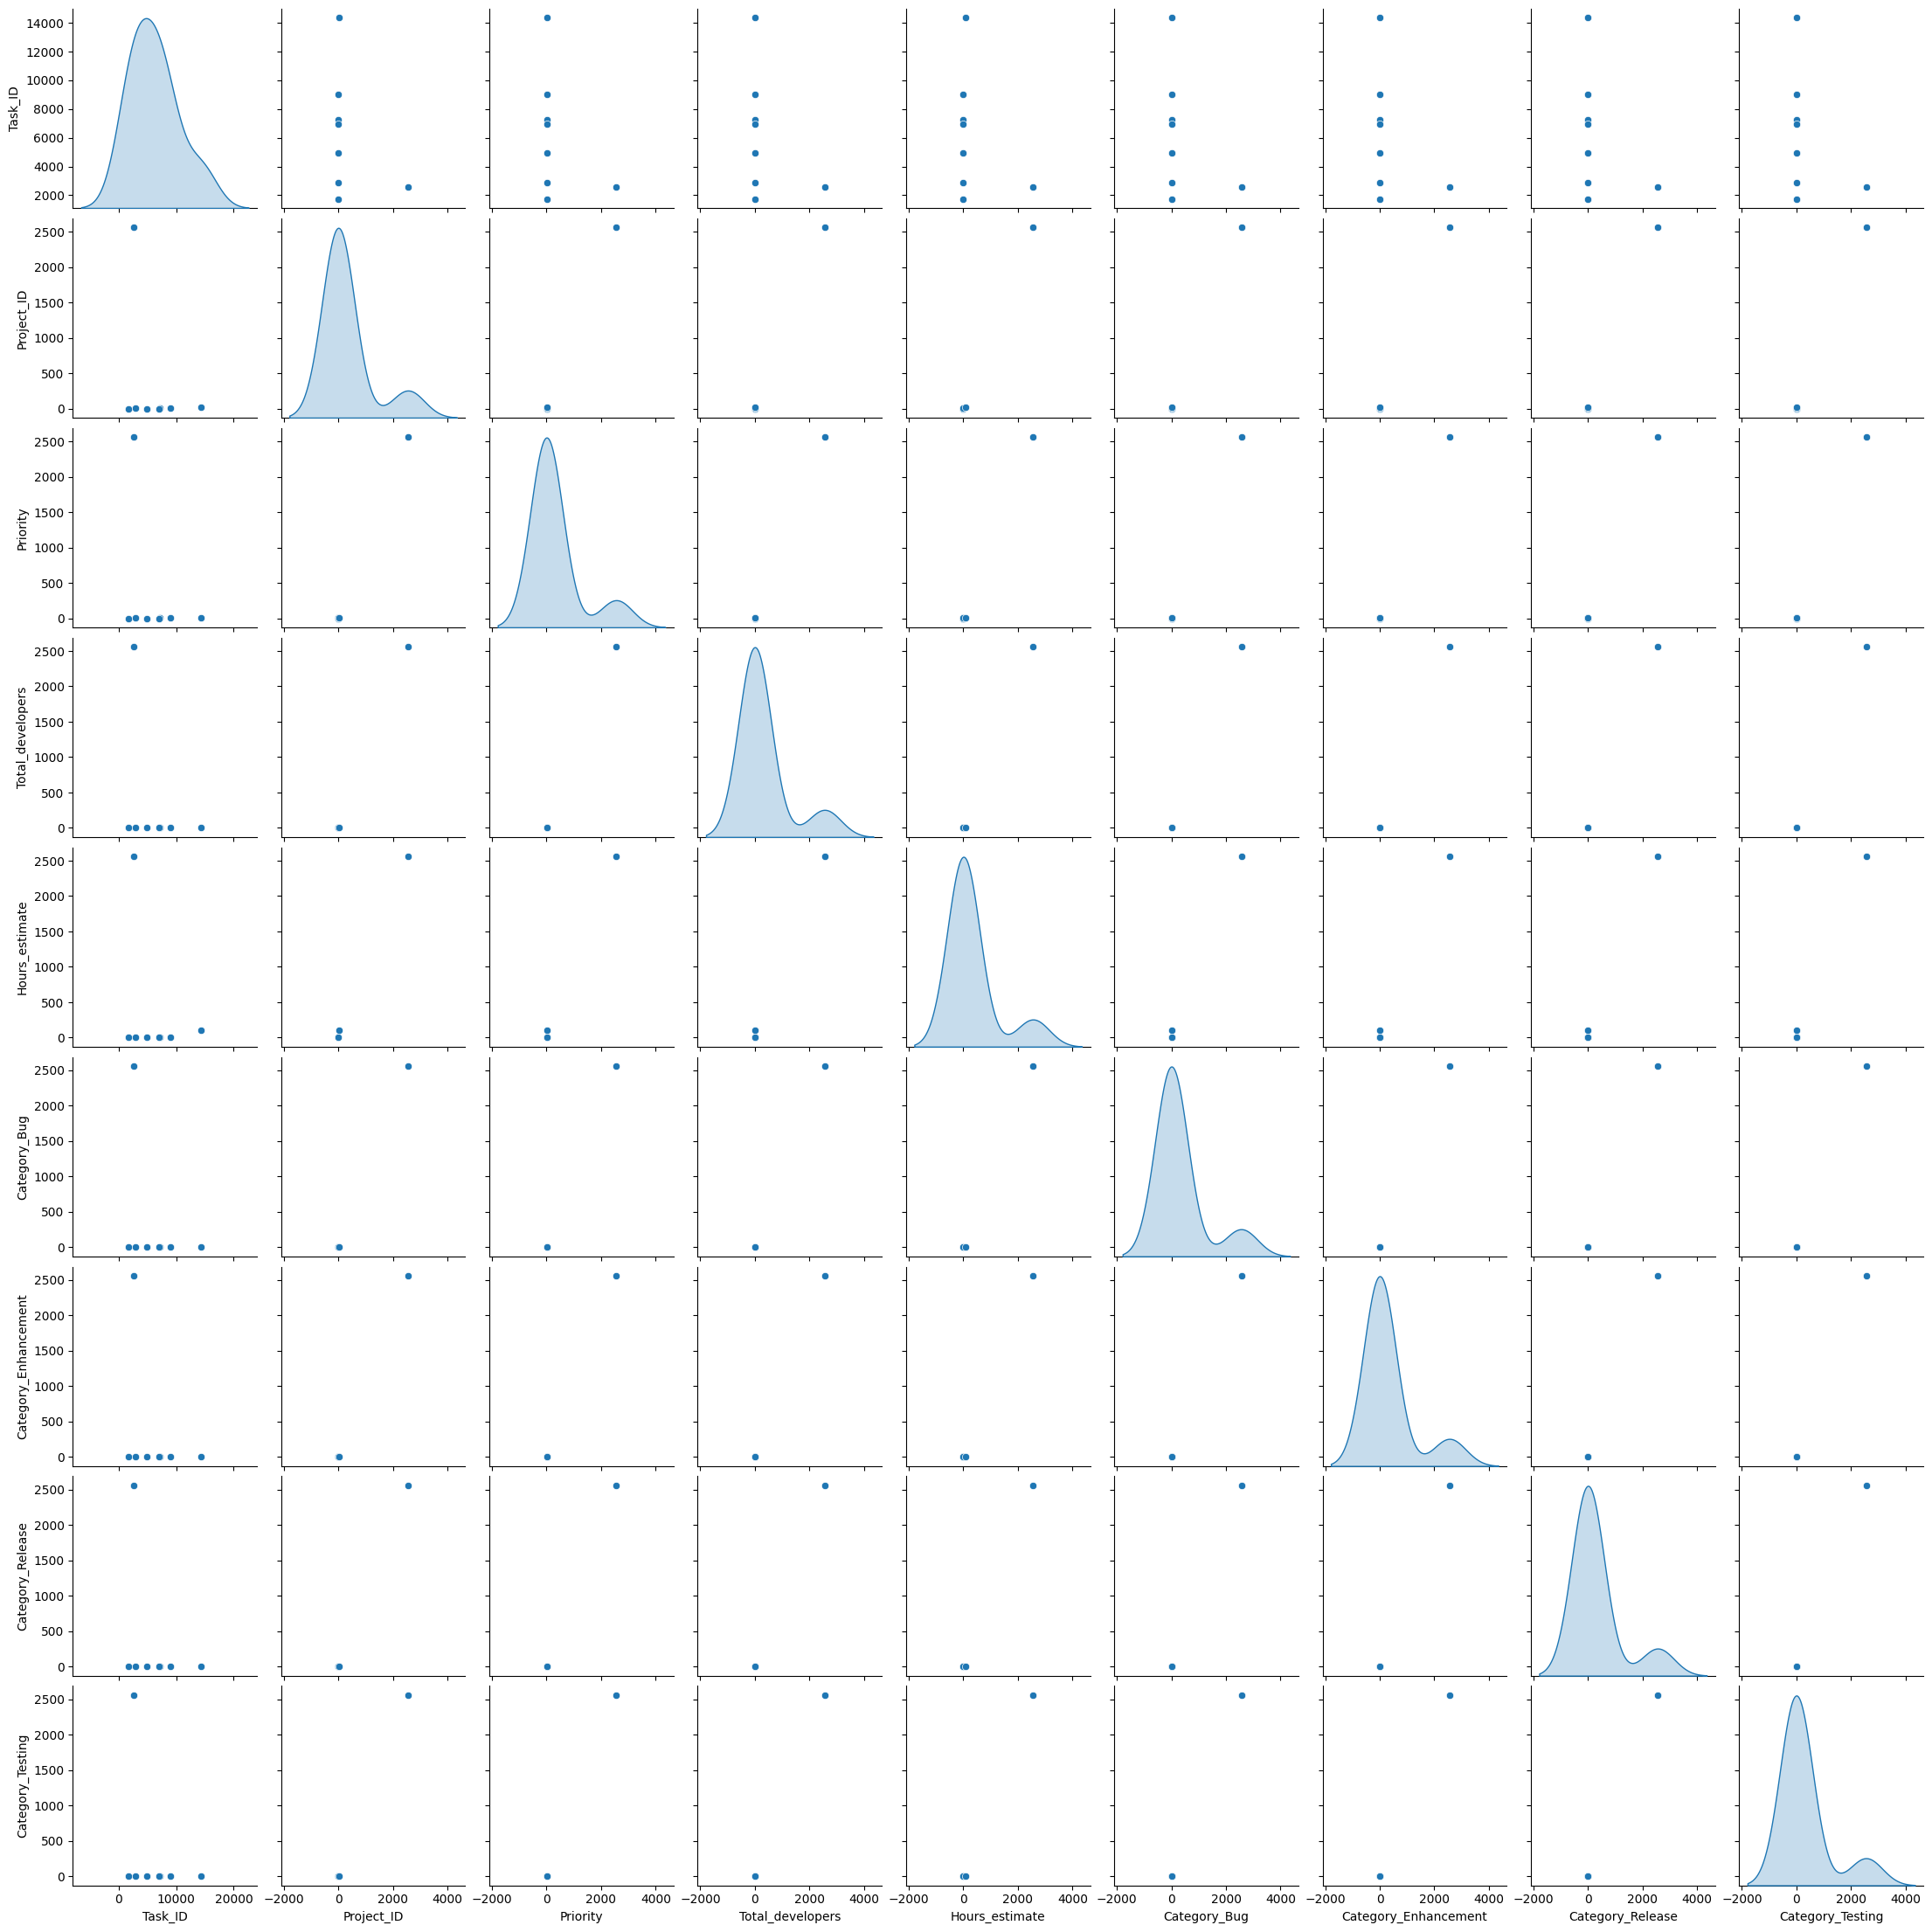

In [10]:
# correlation only between the features 
train_stats = train_dataset.describe()
train_stats.pop("Hours_logged")
sns.pairplot(train_stats[train_stats.columns], diag_kind="kde")

In [9]:
# another interesting statistics 
train_stats = train_dataset.describe()
train_stats.pop("Hours_logged")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Task_ID,2560.0,7134.710547,2868.434320,1742.0,4802.25,6970.5,8902.0,14355.0
Project_ID,2560.0,4.959766,4.275710,2.0,2.00,2.0,9.0,18.0
Priority,2560.0,2.255469,1.789086,1.0,1.00,1.0,3.0,10.0
Total_developers,2560.0,1.000000,0.000000,1.0,1.00,1.0,1.0,1.0
Hours_estimate,2560.0,4.826172,10.364171,0.0,1.00,2.0,7.0,260.0
Category_Bug,2560.0,0.445703,0.497140,0.0,0.00,0.0,1.0,1.0
Category_Enhancement,2560.0,0.423438,0.494200,0.0,0.00,0.0,1.0,1.0
Category_Release,2560.0,0.096875,0.295845,0.0,0.00,0.0,0.0,1.0
Category_Testing,2560.0,0.033984,0.181224,0.0,0.00,0.0,0.0,1.0


### Feature prediction

The label "Hours Logged" is the actual goal for our model, we will remove it from every sample and keep it apart

In [10]:
train_label = train_dataset.pop('Hours_logged')
test_label = test_dataset.pop('Hours_logged')
validation_label = validation_dataset.pop('Hours_logged')

### Data normalization/Scaling

Subtract the mean of the training data and divide by the standard deviation of the training data.

In [11]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
normed_validation_data = norm(validation_dataset)

# temporaly
# recover the original #Developer column
if normed_train_data['Total_developers'].isna().any():
    normed_train_data['Total_developers'] = normed_train_data['Total_developers'].fillna(1)
    normed_test_data['Total_developers'] = normed_test_data['Total_developers'].fillna(1)
    normed_validation_data['Total_developers'] = normed_validation_data['Total_developers'].fillna(1)

In [12]:
# show a part of the normalized data
normed_train_data.head()

,Task_ID,Project_ID,Priority,Total_developers,Hours_estimate,Category_Bug,Category_Enhancement,Category_Release,Category_Testing
3250,-0.884702,-0.692228,-0.142793,1.0,-0.272687,1.114971,-0.856814,-0.327452,-0.187527
2840,1.731708,-0.692228,-0.701737,1.0,-0.272687,1.114971,-0.856814,-0.327452,-0.187527
3341,-0.733749,-0.692228,-0.701737,1.0,-0.369173,-0.896534,1.166658,-0.327452,-0.187527
698,-0.941528,-0.692228,1.534041,1.0,0.209745,1.114971,-0.856814,-0.327452,-0.187527
4051,0.885253,-0.224469,-0.701737,1.0,-0.272687,-0.896534,-0.856814,3.052694,-0.187527


## Building the Neural Network Model

## Firts Model
Two hidden layers with 50 neurons each

Learning rate at 0.001

In [69]:
def build_first_model_two_hidden_layers():
    model = Sequential(name = "FirstModelTwoHiddenLayers")

    # Input layer
    model.add(Dense(10, input_shape = (normed_train_data.shape[1],)))

    # Hidden layer 
    model.add(Dense(50, Activation('relu'), name='hidden_layer_1'))
    model.add(Dense(50, Activation('relu'), name='hidden_layer_2'))

    # Output layer 
    model.add(Dense(1))

    learnig_rate = 0.001
    optimizer = optimizers.RMSprop(learning_rate=learnig_rate)
    model.compile(
        loss='mse',
        optimizer=optimizer,
        metrics=['mae', 'mse']
    )

    return model

### Second Model

Three hidden layers with 32, 64 and 128 neurons, respectively

Learning rate at 0.01

In [45]:
def build_second_model_three_hidden_layers():
    model = Sequential(name = "SecondModelThreeHiddenLayers")

    # Input layer
    model.add(Dense(10, input_shape = (normed_train_data.shape[1],)))

    # Hidden layer 
    model.add(Dense(32, Activation('relu'), name='hidden_layer_1'))
    model.add(Dense(64, Activation('relu'), name='hidden_layer_2'))
    model.add(Dense(128, Activation('relu'), name='hidden_layer_3'))

    # Output layer 
    model.add(Dense(1))

    learnig_rate = 0.01
    optimizer = optimizers.RMSprop(learning_rate=learnig_rate)
    model.compile(
        loss='mse',
        optimizer=optimizer,
        metrics=['mae', 'mse']
    )

    return model

### Third Model

Five hidden layers, all with 64 neurons

Learning rate at 0.001

In [46]:
def build_third_model_five_hidden_layers():
    model = Sequential(name = "ThirdModelFiveHiddenLayers")

    # Input layer
    model.add(Dense(10, input_shape = (normed_train_data.shape[1],)))

    # Hidden layer 
    model.add(Dense(64, Activation('relu'), name='hidden_layer_1'))
    model.add(Dense(64, Activation('relu'), name='hidden_layer_2'))
    model.add(Dense(64, Activation('relu'), name='hidden_layer_3'))
    model.add(Dense(64, Activation('relu'), name='hidden_layer_4'))
    model.add(Dense(64, Activation('relu'), name='hidden_layer_5'))

    # Output layer 
    model.add(Dense(1))

    learnig_rate = 0.01
    optimizer = optimizers.RMSprop(learning_rate=learnig_rate)
    model.compile(
        loss='mse',
        optimizer=optimizer,
        metrics=['mae', 'mse']
    )

    return model

### Fourth Model

Recurrent Neural Network

In [40]:
def build_fourth_model_LSTM_hidden_layers():
    model = Sequential(name = "FourthModelLSTMHiddenLayers")

    model.add(Reshape(
        (normed_train_data.shape[1], 1),
        input_shape=(normed_train_data.shape[1],)
    ))

    model.add(SimpleRNN(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
  
    model.add(Dense(1, Activation('linear')))

    learnig_rate = 0.0001
    optimizer = optimizers.Adam(learning_rate=learnig_rate)
    model.compile(
        loss='mse',
        optimizer=optimizer,
        metrics=['mae', 'mse']
    )

    return model    

### Fith Model

Support Vector Machine

Best params hash: {'kernel': 'linear'}
0.8744658023545171


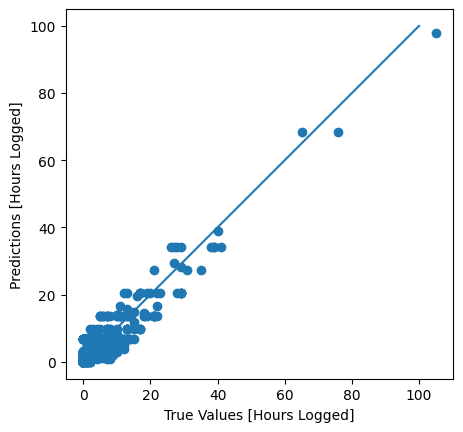

In [56]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':('linear', 'rbf')}

svr = SVR()
LinearSVC = GridSearchCV(svr, parameters)
LinearSVC.fit(normed_train_data, train_label)
print("Best params hash: {}".format(LinearSVC.best_params_))
print(LinearSVC.score(normed_test_data, test_label))

test_predictions = LinearSVC.predict(normed_test_data)
axes = plt.axes(aspect='equal')
plt.scatter(test_label, test_predictions)
plt.xlabel('True Values [Hours Logged]')
plt.ylabel('Predictions [Hours Logged]')
_ = plt.plot([0,100], [0,100])




### Choose the model

To choose the model uncomment the line of the one that you want yo fit

In [41]:
# model = build_first_model_two_hidden_layers()
# model = build_second_model_three_hidden_layers()
# model = build_third_model_five_hidden_layers()
model = build_fourth_model_LSTM_hidden_layers()

Test the model before training (this will use the initial weights) which in fact will generate random values. We will take the first 10 rows

In [36]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

1/1 [==============================] - 0s 288ms/step


array([[-0.37601495],
       [ 0.40730697],
       [ 0.5285344 ],
       [-0.2886277 ],
       [ 1.1156445 ],
       [ 0.62842435],
       [ 0.12366286],
       [ 0.35261232],
       [ 0.55487317],
       [ 0.17929289]], dtype=float32)

Save checkpoints during training

In [42]:
# checkpoint_path = r".\checkpoint_logs\connectium\data.ckpt"
checkpoint_path = r".\checkpoint_logs\sip\data.ckpt"

# Create a callback that saves the model's weights
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_loss', # or val_accuracy if you have it.
                                                 save_best_only=True, # Default false. If you don't change the file name then the output will be overritten at each step and only the last model will be saved.
                                                 save_weights_only=True, # True => model.save_weights (weights and no structure, you need JSON file for structure), False => model.save (saves weights & structure)
                                                 verbose=0,
                                                  )

## Model training

In [46]:
%%time

# for first model - is winning
epochs = 100
batch_size = 64

# for second model
# epochs = 600
# batch_size = 100
# for third model

print("Summary of the model")
model.summary()

history = model.fit(
    normed_train_data,
    train_label,
    batch_size=batch_size,  
    epochs=epochs, 
    verbose=0,
    shuffle=True,
    steps_per_epoch = int(normed_train_data.shape[0] / batch_size),
    validation_data=(normed_validation_data, validation_label),
    callbacks=[
        tfdocs.modeling.EpochDots(),
        ckpt_callback,
    ]
)

Summary of the model
Model: "FourthModelLSTMHiddenLayers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_4 (Reshape)         (None, 9, 1)              0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 9, 128)            16640     
                                                                 
 dropout_3 (Dropout)         (None, 9, 128)            0         
                                                                 
 dense_6 (Dense)             (None, 9, 32)             4128      
                                                                 
 dropout_4 (Dropout)         (None, 9, 32)             0         
                                                                 
 dense_7 (Dense)             (None, 9, 1)              33        
                                                                 
Total params: 2080

Summary of the results after earch epoch

In [47]:
history_dataset = pd.DataFrame(history.history)
history_dataset['epoch'] = history.epoch
history_dataset.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
95,68.400124,3.572958,68.400124,26.053158,3.296112,26.053158,95
96,68.513191,3.599010,68.513191,24.903421,3.215064,24.903421,96
97,68.780441,3.566411,68.780441,24.708744,3.205101,24.708744,97
98,67.625717,3.564823,67.625717,24.718935,3.165147,24.718935,98
99,67.523857,3.573892,67.523857,24.864838,3.132139,24.864838,99


Saving error results

In [38]:
# hystory_dataset.to_csv(r".\outputs\history_connectium.csv")
history_dataset.to_csv(r"./outputs/history_sip.csv", index=False)

### Predicted and real values

Here we will see the first 10 rows of the predicted data, comparing it with the real one

In [39]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
print("Predicted Hours Logged")
example_result

1/1 [==============================] - 0s 28ms/step
Predicted Hours Logged


array([[ 2.6910515],
       [19.926538 ],
       [ 2.4152286],
       [ 5.9020247],
       [ 5.814537 ],
       [ 1.5260801],
       [ 5.9020247],
       [ 1.9827609],
       [ 2.587674 ],
       [ 0.2500162]], dtype=float32)

In [40]:
print("Real Hours Logged")
train_label[:10]

Real Hours Logged


3568     3
301     26
1866     1
250      8
1348     5
1750     1
2544     5
3596     2
1760     2
3442     0
Name: Hours_logged, dtype: int32

## Evaluating the model

The metrics we choose to evaluate the model were **Mean Abs. Error** and **Mean squarred Error**

We will graph the error metrics across epochs and then see how the model evalutes itself

Text(0, 0.5, 'MAE [Hours Logged]')

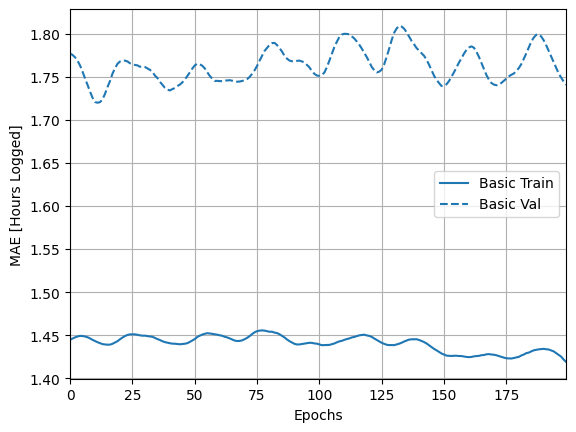

In [41]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = "mae")
plt.ylabel('MAE [Hours Logged]')

### Error rate on Train Sample

In [43]:
loss, mae, mse = model.evaluate(normed_train_data, train_label, verbose=2)

print("Mean Abs Error: {:5.2f} Hours_logged".format(mae))
print("Mean Squared Error: {:5.2f} Hours_logged".format(mse))


80/80 - 0s - loss: 4.4080 - mae: 1.3818 - mse: 4.4080 - accuracy: 0.3383 - 139ms/epoch - 2ms/step


ValueError: too many values to unpack (expected 3)

### Error rate on Validation Sample

In [61]:
loss, mae, mse = model.evaluate(normed_validation_data, validation_label, verbose=2)

print("Mean Abs Error: {:5.2f} Hours Logged".format(mae))
print("Mean Squared Error: {:5.2f} Hours Logged".format(mse))

27/27 - 0s - loss: 9.0173 - mae: 1.9904 - mse: 9.0173 - 70ms/epoch - 3ms/step
Mean Abs Error:  1.99 Hours Logged
Mean Squared Error:  9.02 Hours Logged


## Predicting the data

In [68]:
test_predictions = model.predict(normed_test_data)

test_predictions = pd.DataFrame(test_predictions)

test_predictions.shape

InvalidArgumentError: Graph execution error:

Detected at node SecondModelThreeHiddenLayers/dense_2/BiasAdd defined at (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 196, in _run_module_as_main

  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 86, in _run_code

  File "C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\traitlets\config\application.py", line 1053, in launch_instance

  File "C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\kernelapp.py", line 737, in start

  File "C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\asyncio\base_events.py", line 603, in run_forever

  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\asyncio\base_events.py", line 1909, in _run_once

  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\asyncio\events.py", line 80, in _run

  File "C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\kernelbase.py", line 524, in dispatch_queue

  File "C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\kernelbase.py", line 513, in process_one

  File "C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\kernelbase.py", line 418, in dispatch_shell

  File "C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\kernelbase.py", line 758, in execute_request

  File "C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\ipkernel.py", line 426, in do_execute

  File "C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 3046, in run_cell

  File "C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 3101, in _run_cell

  File "C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 3306, in run_cell_async

  File "C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 3488, in run_ast_nodes

  File "C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 3548, in run_code

  File "C:\Users\franc\AppData\Local\Temp\ipykernel_10100\1143835201.py", line 1, in <module>

  File "C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py", line 2655, in predict

  File "C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py", line 2440, in predict_function

  File "C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py", line 2425, in step_function

  File "C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py", line 2413, in run_step

  File "C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py", line 2381, in predict_step

  File "C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py", line 590, in __call__

  File "C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\sequential.py", line 398, in call

  File "C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\functional.py", line 515, in call

  File "C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\functional.py", line 672, in _run_internal_graph

  File "C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py", line 252, in call

Matrix size-incompatible: In[0]: [32,10], In[1]: [9,10]
	 [[{{node SecondModelThreeHiddenLayers/dense_2/BiasAdd}}]] [Op:__inference_predict_function_512022]

Predictions VS. True Values for Hours Logged

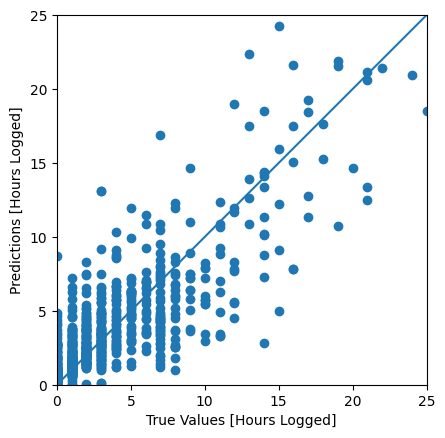

In [68]:
axes = plt.axes(aspect='equal')
plt.scatter(test_label, test_predictions)
plt.xlabel('True Values [Hours Logged]')
plt.ylabel('Predictions [Hours Logged]')
lims = [0, 25]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

Saving the predicted values as a csv file